In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, StrMethodFormatter

In [2]:
# import and format the data
tests = pd.read_csv("ss21_processed_solutions/tests_data.csv")
tests["num_tests_passed"] = tests[["test_1", "test_2", "hidden_test_1", "hidden_test_2"]].sum(axis=1)
tests["%_tests_passed"] = tests["num_tests_passed"]/4*100
tests["source"] = tests["source"].replace({"bard":"Bard", "gpt3.5":"ChatGPT-3.5", "bing":"Bing", "gpt4":"ChatGPT-4", "student":"Human"})

In [5]:
# additional information for the plots
colours = {"Human": (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
           "Bard": (1.0, 0.8509803921568627, 0.1843137254901961),
           "Bing": (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           "ChatGPT-3.5": (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           "ChatGPT-4": (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}
plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"legend.handlelength": 2,
                     "legend.handleheight": 1.5})

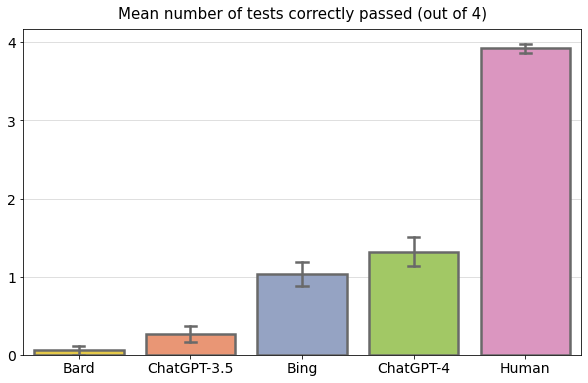

In [6]:
# create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot the barchart
sns.barplot(data=tests, 
            x="source", 
            y="num_tests_passed", 
            errorbar="se", 
            capsize=0.1, 
            errcolor="dimgray", 
            errwidth=2.5,
            zorder=2, 
            linewidth=2.5, 
            edgecolor="dimgray", 
            palette=colours, 
            order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
            ax=ax)

# set the labels
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_title("Mean number of tests correctly passed (out of 4)", fontsize=15, pad=10)
ax.grid(zorder=-1, alpha=0.5, axis="y");

In [7]:
# creating a dataframe containing the % of solutions in each combination of source and number of tests passed
grouped_tests = pd.crosstab(tests["source"], tests["num_tests_passed"], normalize="index").reset_index()
grouped_tests = grouped_tests.set_index("source").stack().reset_index().sort_values(["source", "num_tests_passed"])
grouped_tests.columns = ["source", "num_tests_passed", "percent"]
grouped_tests["percent"] = np.round(grouped_tests["percent"]*100, 5)

# sorting the order of the rows for the plot
grouped_tests["source"] = pd.Categorical(grouped_tests["source"], ["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"])
grouped_tests["num_tests_passed"] = pd.Categorical(grouped_tests['num_tests_passed'], [4,3,2,1,0])
grouped_tests = grouped_tests.sort_values(["source", "num_tests_passed"]).reset_index(drop=True)
grouped_tests = grouped_tests[grouped_tests["percent"] != 0].reset_index(drop=True)

# store the sample sizes of each source as a proportion of the whole dataset
sample_sizes_ratio = tests.groupby("source").count()["name"] / tests.groupby("source").count()["name"].sum()
grouped_tests["sample_size"] = grouped_tests["source"].apply(lambda source: sample_sizes_ratio[source])

# creating dictionaries matching sources to values and sample sizes to use in the plot
source_to_sample_size = grouped_tests[["source", "sample_size"]].drop_duplicates().set_index("source").squeeze(axis=1).to_dict()
percent_to_source = grouped_tests[["percent", "source"]].replace(0, np.nan).dropna().set_index("percent").squeeze(axis=1).to_dict()

# calculating the positions of each bar in the plot, given the sample size (width)
positions = [value * 5 for value in np.cumsum([0] + list(source_to_sample_size.values()))]
tick_positions = [(positions[i] + positions[i+1]) / 2 for i in range(0, 5)]
source_to_position = pd.DataFrame(positions[:-1], ["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"]).squeeze(axis=1).to_dict()

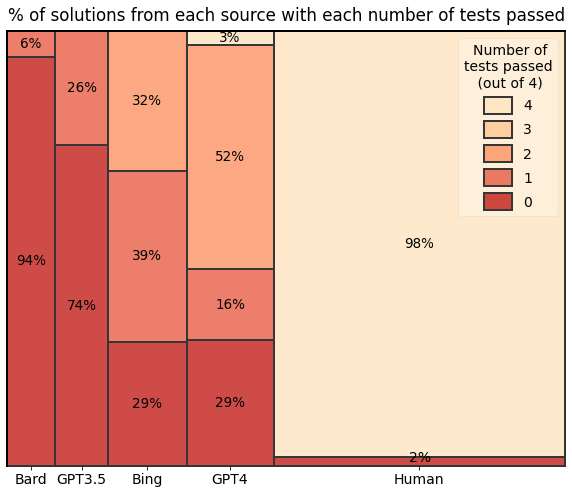

In [8]:
# create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# create the base for the mosiac plot as a stacked histogram
ax = sns.histplot(data=grouped_tests, 
                  x="source", 
                  weights="percent", 
                  hue="num_tests_passed", 
                  multiple="stack", 
                  palette="OrRd", # using a colorbrewer palette
                  linewidth=2, 
                  edgecolor="#363636")

# set the labels
ax.set_ylim(0, 100),
ax.set_xlim(0, 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([])
ax.set_xticks(tick_positions)
ax.set_xticklabels(["Bard", "GPT3.5", "Bing", "GPT4", "Human"])
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.set_title("% of solutions from each source with each number of tests passed", pad=10)

# adjust the width of each bar to correspond to the sample sizes
for rect in ax.patches:
    current_width = rect.get_width()
    current_height = np.round(rect.get_height(), 5)
    if current_width != 0 and current_height != 0:
        rect.set_width(ax.get_xlim()[1] * source_to_sample_size[percent_to_source[current_height]])
        rect.set_x(source_to_position[percent_to_source[current_height]])

# set percentage labels in the center of each bar
for container in ax.containers:
    labels = [f"{int(np.floor(value.get_height() + 0.5))}%" if value.get_height() > 2 else "" for value in container]
    ax.bar_label(container, 
                 labels=labels, 
                 label_type='center', 
                 size=13.5)
ax.text(3.6, 1,  "2%")

# create the legend
legend = ax.get_legend()
legend.set_title("  Number of\ntests passed\n   (out of 4)")
legend.get_frame().set_alpha(0.3)

In [10]:
tests_passed_style = tests.groupby("style").mean().reset_index().sort_values("%_tests_passed")

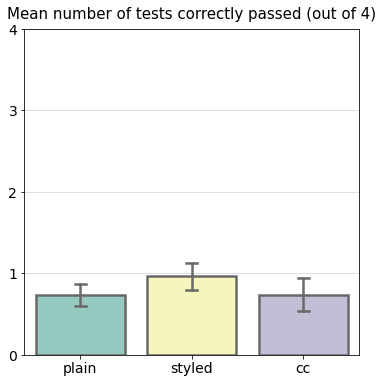

In [11]:
# create the plot
sns.set_palette("Set3")
fig, ax = plt.subplots(figsize=(6, 6))

# plot the barchart
sns.barplot(data=tests, 
            x="style", 
            y="num_tests_passed", 
            errorbar="se", 
            capsize=0.1, 
            errcolor="dimgray", 
            errwidth=2.5,
            zorder=2, 
            linewidth=2.5, 
            edgecolor="dimgray", 
            ax=ax)

# set the labels
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_title("Mean number of tests correctly passed (out of 4)", fontsize=15, pad=10)
ax.grid(zorder=-1, alpha=0.5, axis="y");

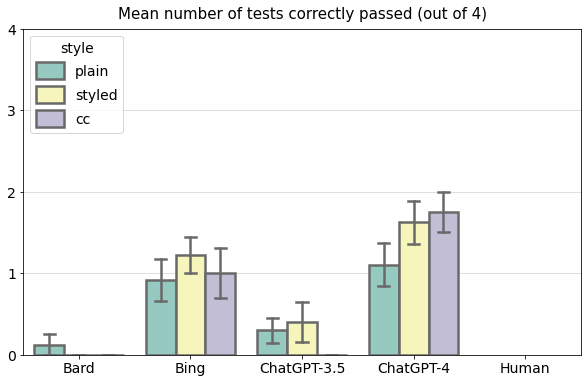

In [12]:
# create the plot
sns.set_palette("Set3")
fig, ax = plt.subplots(figsize=(10, 6))

# plot the barchart
sns.barplot(data=tests, 
            x="source", 
            y="num_tests_passed", 
            hue="style",
            #palette=colours,
            errorbar="se", 
            capsize=0.1, 
            errcolor="dimgray", 
            errwidth=2.5,
            zorder=2, 
            linewidth=2.5, 
            edgecolor="dimgray", 
            ax=ax)

# set the labels
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_title("Mean number of tests correctly passed (out of 4)", fontsize=15, pad=10)
ax.grid(zorder=-1, alpha=0.5, axis="y");